In [1]:
import numpy as np
import sklearn
from scipy.stats.stats import pearsonr
import pickle
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from numpy import genfromtxt
from random import shuffle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3894605808385913958
]


In [2]:
Count_full = np.array([22310,  3960,  3500,  1770,  3172,  3710,  2390,  1470,  1230,
        2150,  2380,  5722,  1924,  1920,  3532,  2600,  2264,  6910,
        6520,  4344,  1310,  1150,  2714,  2380,  2712,  6224,  2318,
        2636,  2646,  1410,  1410,  2950,  1410,  1100,  1240,  1310,
        1580,  1790,  1724,  2042,  1860,  1010,  1528,  5462,  5720,
        2778,  1408,  6330,  2040,  4960,  1660,  1570,  1450,  1090,
        4632,  1438,  1418,  3300,  1220,  3624,  1400,  1524,  1160,
        3486,  2030,  2200,  2694,  5750,  1522,  1950,  1280,  1910,  5834])

In [3]:
length_folders = np.array([10, 13, 20, 14, 16])

# Get the name of the files and folders

In [4]:
def GetName(path):
    Folder = []
    r = []
    Subfolder = []
    full_path = []
    count_list = []
    for folder in os.listdir(path):
        count = 0
        Folder.append(folder)
        for subfolder in os.listdir(path+'/'+folder):
            Subfolder.append(subfolder)
            for files in os.listdir(path+'/'+folder+'/'+subfolder):
                if os.path.splitext(files)[1] == ".pts":
                    r.append(files) 
                    full_path.append(folder+'/'+subfolder+'/'+files)
                    count += 1
        count_list.append(count)
    return Folder, Subfolder, r, full_path, count_list

In [5]:
# Get what we need for each FOLD (1,2,3,4,5) for two people involved

# for FOLD_1
path = r"C:/Users/pinouche/Downloads/FOLD_1/"
Folders_Fold1, Subfolders_Fold1, Files_Fold1, Full_path_Fold1, count_list_FOLD1 = GetName(path)

In [6]:
# FOLD 2
path = r"C:/Users/pinouche/Downloads/FOLD_2/"
Folders_Fold2, Subfolders_Fold2, Files_Fold2, Full_path_Fold2, count_list_FOLD2 = GetName(path)

In [7]:
# FOLD 3
path = r"C:/Users/pinouche/Downloads/FOLD_3/"
Folders_Fold3, Subfolders_Fold3, Files_Fold3, Full_path_Fold3, count_list_FOLD3 = GetName(path)

In [8]:
# FOLD 4
path = r"C:/Users/pinouche/Downloads/FOLD_4/"
Folders_Fold4, Subfolders_Fold4, Files_Fold4, Full_path_Fold4, count_list_FOLD4 = GetName(path)

In [9]:
#FOLD 5
path = r"C:/Users/pinouche/Downloads/FOLD_5/"
Folders_Fold5, Subfolders_Fold5, Files_Fold5, Full_path_Fold5, count_list_FOLD5 = GetName(path)

In [10]:
# concat the folders above and print some information about the shapes

Folders_full = np.concatenate([Folders_Fold1, Folders_Fold2, Folders_Fold3, Folders_Fold4, Folders_Fold5])
Count_full = np.concatenate([count_list_FOLD1, count_list_FOLD2, count_list_FOLD3, count_list_FOLD4, count_list_FOLD5])
Full_path_full = np.concatenate([Full_path_Fold1, Full_path_Fold2, Full_path_Fold3, Full_path_Fold4, Full_path_Fold5])
print([Folders_full.shape, Count_full.shape, Full_path_full.shape])

[(73,), (73,), (213072,)]


# Load the data

In [11]:
# Retrieve the data for FOLD1

Full_data_x = pickle.load( open( "Full_data_x.p", "rb" ))
print(Full_data_x.shape)

(213072, 68, 2)


In [12]:
# Retrieve the data for FOLD1

data_x = pickle.load( open( "data_x.p", "rb" ))
print(data_x.shape)

(106536, 196)


In [13]:
# Retrieve the annotations

annotation_vector_Two = pickle.load( open( "annotation_vector_Two.p", "rb" ))
print(annotation_vector_Two.shape)

(73,)


# scale the data

In [14]:
# get the participants separated

from sklearn import preprocessing

data_participant1 = data_x[:,:98]
data_participant2 = data_x[:,98:]
participant1_scaled = preprocessing.scale(data_participant1)
participant2_scaled = preprocessing.scale(data_participant2)
data_x = preprocessing.scale(data_x)

C:\Users\pinouche\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype <U7 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# Smooth the response data

In [15]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

def SmoothResponse(response_list = annotation_vector_Two):
    length = len(annotation_vector_Two)
    gauss_kernel_40 = Gaussian1DKernel(25)
    gauss_kernel_50 = Gaussian1DKernel(50)
    gauss_kernel_75 = Gaussian1DKernel(75)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF50 = []
    annotation_RBF75 = []
    annotation_RBF100 = []
    for index in range(length):
        response_list[index] = np.reshape(response_list[index], (response_list[index].shape[0],))
        
        Ann40 = convolve(response_list[index], gauss_kernel_40)
        Ann40[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann40 = np.reshape(Ann40, (response_list[index].shape[0],1))
        
        Ann50 = convolve(response_list[index], gauss_kernel_50)
        Ann50[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann50 = np.reshape(Ann50, (response_list[index].shape[0],1))
        
        Ann75 = convolve(response_list[index], gauss_kernel_75)
        Ann75[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann75 = np.reshape(Ann75, (response_list[index].shape[0],1))
        
        Ann100 = convolve(response_list[index], gauss_kernel_100)
        Ann100[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann100 = np.reshape(Ann100, (response_list[index].shape[0],1))
    
        annotation_RBF40.append(Ann40)
        annotation_RBF50.append(Ann50)
        annotation_RBF75.append(Ann75)
        annotation_RBF100.append(Ann100)
           
    return annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 

In [16]:
annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 = SmoothResponse()
print([len(annotation_RBF40), len(annotation_RBF50), len(annotation_RBF75), len(annotation_RBF100)])
print([annotation_RBF40[0].shape, annotation_RBF50[0].shape, annotation_RBF75[0].shape, annotation_RBF100[0].shape])

[73, 73, 73, 73]
[(11155, 1), (11155, 1), (11155, 1), (11155, 1)]


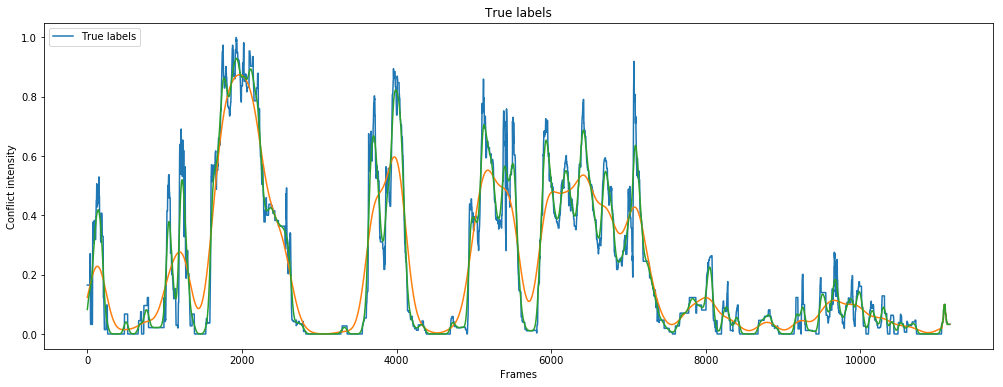

In [17]:
# Plot a few video sequences to see if smoothing is justified

fig = plt.figure(figsize=(17, 6))
plt.plot(annotation_vector_Two[0])
plt.plot(annotation_RBF100[0])
plt.plot(annotation_RBF40[0])
plt.title('True labels')
plt.ylabel('Conflict intensity')
plt.xlabel('Frames')
plt.legend(['True labels'], loc='upper left')
plt.show()

# Prepare data to feed into NN

In [18]:
def Makelist(data,Count):
    Count = Count/2
    list_data = []
    ball = 0
    for index in range(0,len(Count)):
        list_data.append(data[ball:(ball+int(Count[index])),:])
        ball += int(Count[index])
    return(np.asarray(list_data))

In [19]:
list_data_x = Makelist(data_x, Count_full)

In [20]:
# put the things into FOLDS

def DoFOLDS(list_data, annotation_list_smooth, annotation_list, num_folder1=len(Folders_Fold1), num_folder2=len(Folders_Fold2), num_folder3=len(Folders_Fold3), num_folder4=len(Folders_Fold4), num_folder5=len(Folders_Fold5)):
    Fold1 = []
    Fold2 = []
    Fold3 = []
    Fold4 = []
    Fold5 = []
    Fold1_y_smooth = []
    Fold2_y_smooth = []
    Fold3_y_smooth = []
    Fold4_y_smooth = []
    Fold5_y_smooth = []
    Fold1_y = []
    Fold2_y = []
    Fold3_y = []
    Fold4_y = []
    Fold5_y = []
    
    for index in range(num_folder1):
        Fold1.append(list_data[index])
        Fold1_y_smooth.append(annotation_list_smooth[index])
        Fold1_y.append(annotation_list[index])
    for index in range(num_folder1, num_folder1+num_folder2):
        Fold2.append(list_data[index])
        Fold2_y_smooth.append(annotation_list_smooth[index])
        Fold2_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2,num_folder1+num_folder2+num_folder3):
        Fold3.append(list_data[index])
        Fold3_y_smooth.append(annotation_list_smooth[index])
        Fold3_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2+num_folder3,num_folder1+num_folder2+num_folder3+num_folder4):
        Fold4.append(list_data[index])
        Fold4_y.append(annotation_list[index])
        Fold4_y_smooth.append(annotation_list_smooth[index])
    for index in range(num_folder1+num_folder2+num_folder3+num_folder4,num_folder1+num_folder2+num_folder3+num_folder4+num_folder5):
        Fold5.append(list_data[index])
        Fold5_y_smooth.append(annotation_list_smooth[index])
        Fold5_y.append(annotation_list[index])
    
    assert (len(Fold1)+len(Fold2)+len(Fold3)+len(Fold4)+len(Fold5)) == 73
    
    return Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y

Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y = DoFOLDS(list_data_x, annotation_RBF40, annotation_vector_Two)

In [21]:
#Test number must be either 1,2,3,4,5

def MakeTrainValTest(test_number, Fold1=Fold1, Fold2=Fold2, Fold3=Fold3, Fold4=Fold4, Fold5=Fold5, Fold1_y=Fold1_y, Fold2_y=Fold2_y, Fold3_y=Fold3_y, Fold4_y=Fold4_y, Fold5_y=Fold5_y, Fold1_y_smooth=Fold1_y_smooth, Fold2_y_smooth=Fold2_y_smooth, Fold3_y_smooth=Fold3_y_smooth, Fold4_y_smooth=Fold4_y_smooth, Fold5_y_smooth=Fold5_y_smooth):
    list_Folds = list([Fold1, Fold2, Fold3, Fold4, Fold5])
    list_Folds_y = list([Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y])
    list_Folds_y_smooth = list([Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth])
    number_val_test = []
    Train_list = []
    Val_list = []
    Test_list = []
    Train_list_y = []
    Val_list_y = []
    Test_list_y = []
    length = 0
    
    Test_list = list_Folds[test_number-1]
    Test_list_y = list_Folds_y[test_number-1]
    number_val_test.append(test_number-1)
    
    if(test_number == 1):
        Val_list = list_Folds[4]
        Val_list_y = list_Folds_y[4]
        number_val_test.append(4)
    else:
        Val_list = list_Folds[test_number-2]
        Val_list_y = list_Folds_y[test_number-2]
        number_val_test.append(test_number-2)
    
    for index in range(5):
        length = len(list_Folds[index])
        if(index != number_val_test[0] and index != number_val_test[1]):
            for index2 in range(length):
                Train_list.append(list_Folds[index][index2])
                Train_list_y.append(list_Folds_y_smooth[index][index2])       
    
    return Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y 

In [22]:
Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(1)

In [23]:
# Make the Val_list_y of interest from above in 3 classes (low, medium, high) of conflict

def MakeOneHot(val_list_y):
    new_list = []
    a = np.array([1,0,0])
    b = np.array([0,1,0])
    c = np.array([0,0,1])
    for index in range(len(val_list_y)):
        for element in val_list_y[index]:
            if(element < 1/3):
                new_list.append(a)
            elif(element >= 1/3 and element < 2/3):
                new_list.append(b)
            elif(element >= 2/3):
                new_list.append(c)
    return(new_list)

In [24]:
# function to compute the class accuracy

def ComputeAccuracy(True_classes_list, predicted_classes_list):
    accuracy = 0
    assert len(True_classes_list) == len(predicted_classes_list)
    for index in range(len(True_classes_list)):
        if(all (True_classes_list[index] == predicted_classes_list[index])):
            accuracy += 1
    accuracy /= len(predicted_classes_list)
    return(accuracy)

In [25]:
def MakeOneHotTrain(train_list_y):
    new_list = []
    final_list = []
    a = np.array([1,0,0])
    b = np.array([0,1,0])
    c = np.array([0,0,1])
    length = 0
    count = 0
    for index in range(len(train_list_y)):
        length = len(train_list_y[index])
        for element in train_list_y[index]:
            if(element < 1/3):
                new_list.append(a)
            elif(element >= 1/3 and element < 2/3):
                new_list.append(b)
            elif(element >= 2/3):
                new_list.append(c)
        final_list.append(np.asarray(new_list[count:count+length]))
        count += length
    return(final_list)

In [26]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def SoftMaxFlatten(crocker):
    finalList=[]
    for element in crocker:
        for sub_element in element:
            smax=softmax(sub_element)
            b = np.zeros_like(smax)
            b[np.where(smax==np.max(smax))] = 1
            finalList.append(b)
            
    return finalList

In [27]:
def PearsonCor(pred_val_list, val_list_y):
    pearson_cor = 0
    assert len(pred_val_list) == len(val_list_y)
    for index in range(len(pred_val_list)):
        pearson_cor += pearsonr(np.reshape(pred_val_list[index], (pred_val_list[index].shape[0],)), np.reshape(val_list_y[index], (val_list_y[index].shape[0],)))[0]
        print(pearson_cor)
    return(pearson_cor/len(pred_val_list))       

# Bidirectional plus LSTM 

In [33]:
def SwitchDim(a):
    for i in range(np.shape(a)[:2][0]):
        for j in range(np.shape(a)[:2][1]-1):
            a[i][j], a[i][j+1] = a[i][j+1], a[i][j]
    a = np.asarray(a)
    return(a)

In [173]:
timesteps_1 = 2
window_size = 50
batch_size = window_size
n_epochs = 10

# Hidden layer for the LSTMs
hidden_size_bilstm = 64
hidden_size_mainlstm = 64

# Hidden size for the fully connected layer
FC1 = 32

num_input = 98
epsilon = 0.001
beta = 0.2
learning_rate = 0.000005

In [174]:
def BidirectionalLSTM(train_x, train_y, val_x, val_y,hidden_size_bilstm=hidden_size_bilstm, hidden_size_mainlstm=hidden_size_mainlstm, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon, learning_rate=learning_rate):
    
    
    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [window_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")

    # Bidirectional lstm with different weights
    #with tf.variable_scope('lstm_cell_forward'):
    #    lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    #with tf.variable_scope('lstm_cell_backward'):
    #    lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    # Bidirectional lstm with shared weights 
    with tf.variable_scope('lstm_cell_bidirectional'):
        lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    with tf.variable_scope('lstm_cell_bidirectional', reuse=True):
        lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)

     
    with tf.variable_scope("lstm_bidirectional"):
        bi_outputs, _, _ = tf.nn.static_bidirectional_rnn(lstm_cell_f, lstm_cell_b, inputs = X, dtype= tf.float32)
        last_output = bi_outputs[-1]
        last_output = tf.nn.dropout(last_output, prob)
        last_output = tf.reshape(last_output, (1, window_size, hidden_size_bilstm*2))
        last_output = tf.transpose(last_output, [1, 0, 2])
        last_output = tf.unstack(last_output)
    
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=last_output,dtype=tf.float32)
        lstm_outputs2 = tf.nn.dropout(lstm_outputs2, prob)
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.squeeze(BN3)
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        
    
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN4, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name))
        loss += l2

    
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (window_size, 2, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (window_size, 2, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val

In [175]:
# Best so far: 32, 16, 0.0001, beta= 0.02 (0.0711) for test_number = 1

#lowest_loss_list = []

#for index in range(5):
#    Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(index+1)
#    lowest_loss, min_index, loss, predictions_val, predictions_train = NeuralNetMethod1(Train_list, Train_list_y, Val_list, Val_list_y, 0.0001, 196,64, 16)
#    lowest_loss_list.append(lowest_loss)

lowest_loss, min_index, val_loss, train_loss_list, pred_val = BidirectionalLSTM(Train_list, Train_list_y, Val_list, Val_list_y)

Epoch 1 done.
Step: 1 MSE val loss is 0.119942684559 MSE training loss 0.0991935588838
The total of good classification is: 0.32912809034489776
Epoch 2 done.
Step: 2 MSE val loss is 0.0986514492726 MSE training loss 0.0592096966858
The total of good classification is: 0.37058703835588563
Epoch 3 done.
Step: 3 MSE val loss is 0.094279270818 MSE training loss 0.0673575739636
The total of good classification is: 0.3184962864991352
Epoch 4 done.
Step: 4 MSE val loss is 0.0843427105798 MSE training loss 0.0719806742133
The total of good classification is: 0.3184962864991352
Epoch 5 done.
Step: 5 MSE val loss is 0.0854685930702 MSE training loss 0.0716487466633
The total of good classification is: 0.3184962864991352
Epoch 6 done.
Step: 6 MSE val loss is 0.136529021886 MSE training loss 0.0745005085039
The total of good classification is: 0.38223623969885034
Epoch 7 done.
Step: 7 MSE val loss is 0.0914544008403 MSE training loss 0.0766590509479
The total of good classification is: 0.318496286

KeyboardInterrupt: 

In [176]:
tf.reset_default_graph()

In [860]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(val_y, predictions_val)

# FeedForward on concatenated but for classification task

In [1092]:
epsilon = 0.001
beta = 0.02
batch_size = 32
#hidden_size1 = 32
#hidden_size2 = 32
#learning_rate = 0.00001
n_epochs = 50

In [1102]:
def NeuralNetClassif(train_x, train_y, val_x, val_y, learning_rate, input_size, hidden_size1, hidden_size2, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon):
    
    train_y = MakeOneHotTrain(train_y)
    val_y = MakeOneHotTrain(val_y)
    flatten_val_y = []
    for element in Val_list_y:
        for element1 in element:
            flatten_val_y.append(np.reshape(element1, (1,1)))
    flatten_val_y = MakeOneHot(flatten_val_y)
            
    X = tf.placeholder(shape = [None, input_size], dtype = tf.float32, name = "input")
    y = tf.placeholder(shape = [None, 3], dtype = tf.float32, name = "label")
    
    # Layer 1
    W_input = tf.Variable(tf.random_normal(shape = [input_size, hidden_size1], stddev = 0.1), name = "weights_input", trainable = True)
    
    hidden_units_1 = tf.matmul(X, W_input)
    batch_mean1, batch_var1 = tf.nn.moments(hidden_units_1,[0])
    scale1 = tf.Variable(tf.ones([hidden_size1]))
    beta1 = tf.Variable(tf.zeros([hidden_size1]))
    BN1 = tf.nn.batch_normalization(hidden_units_1,batch_mean1, batch_var1, beta1, scale1, epsilon)
    relu_hidden_1 = tf.nn.relu(BN1, name = "ReLu_hidden_layer")
    
    # Layer 2
    W_hidden1 = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden1", trainable = True)
    
    hidden_units_2 = tf.matmul(relu_hidden_1, W_hidden1)
    batch_mean2, batch_var2 = tf.nn.moments(hidden_units_2,[0])
    scale2 = tf.Variable(tf.ones([hidden_size2]))
    beta2 = tf.Variable(tf.zeros([hidden_size2]))
    BN2 = tf.nn.batch_normalization(hidden_units_2,batch_mean2, batch_var2, beta2, scale2, epsilon)
    relu_hidden_2 = tf.nn.relu(BN2, name = "ReLu_hidden_layer")
    
    # Output layer
    W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 3], stddev = 0.1), name ="weights_hidden2", trainable = True)
    
    # For mean square loss
    logits = tf.matmul(relu_hidden_2, W_hidden2)
    entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss')
     
    regularizer = tf.norm(W_input, ord = 2)
    regularizer1 = tf.norm(W_hidden1, ord = 2)
    regularizer2 = tf.norm(W_hidden2, ord = 2)
    loss = tf.reduce_mean(entropy+ beta * (regularizer+regularizer1+regularizer2))
    
    global_step = tf.Variable(0, trainable=False)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []
        
        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            n_batches = int(train_x[index1].shape[0]/batch_size)
            
            for index in range(n_batches):
                X_batch = train_x[index1][index*batch_size:index*batch_size+batch_size,:]
                Y_batch = train_y[index1][index*batch_size:index*batch_size+batch_size,:]
                _, Loss = sess.run([optimizer, loss], feed_dict = {X: X_batch, y: Y_batch})
                train_loss += Loss
            train_loss /= n_batches
            train_loss_list.append(train_loss)
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
    
        if(i % 2 == 0):
            total_loss = 0
            
            for index in range(len(val_x)):
                X_batch = val_x[index]
                Y_batch = val_y[index]
                
                loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X: X_batch, y: Y_batch})
                total_loss += loss_batch
                pred_val.append(logits_batch)
               
            pred_val_classes = SoftMaxFlatten(pred_val)
            accuracy = ComputeAccuracy(flatten_val_y, pred_val_classes)          
                
            total_loss /= len(val_x)
            val_loss.append(total_loss)
            print("Step: " + str(i) + " MSE val loss {0}".format(total_loss) + " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            saver.save(sess, 'checkpoints/lstm/method1', i)
            
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, total_loss, pred_val

In [1105]:
lowest_loss, min_index, loss, predictions_val= NeuralNetClassif(Train_list, Train_list_y, Val_list, Val_list_y, 0.00001, 196, 32, 32)

INFO:tensorflow:Restoring parameters from checkpoints/lstm\method1-10
Step: 2 MSE val loss 1.3144647032022476 MSE training loss 1.29570813838
The total of good classification is: 0.3707073671852069
Step: 4 MSE val loss 1.3108746334910393 MSE training loss 1.29121334484
The total of good classification is: 0.37090304275511204
Step: 6 MSE val loss 1.3077977299690247 MSE training loss 1.28728473353
The total of good classification is: 0.36943547598082377
Step: 8 MSE val loss 1.3044640198349953 MSE training loss 1.28314689324
The total of good classification is: 0.3693865570883475
Step: 10 MSE val loss 1.3009257540106773 MSE training loss 1.27853921423
The total of good classification is: 0.36894628705606103
The lowest validation loss is at epoch 10 is: 1.30092575401


# Method with the LSTM for the two participants to be used in another LSTM

In [67]:
def ManyToOne(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[window_size-1+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled  

In [68]:
def ManyToMany(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[index:window_size+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled 

In [63]:
epsilon = 0.001
LSTM1 = 64
LSTM2 = 64
FCL = 32

hidden_size = LSTM1
hidden_size1 = LSTM2
hidden_size2 = FCL

learning_rate = 0.00001
beta = 0.02

n_epochs = 10

In [57]:
# Network Parameters particular to the LSTM. We feed the person 1 and then the person 2

num_input1 = 98 # num_of_features
timesteps_1 = 2 # timesteps for the first LSTM = number of participants
window_size = 10 # timesteps for the second LSTM = number of frames
timesteps_2 = window_size
batch_size = timesteps_2

In [65]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input1=num_input1, timesteps_1=timesteps_1, timesteps_2=timesteps_2):

    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input1], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        print(X)
        y = tf.placeholder(shape = [1,1], dtype = tf.float32, name = "label_annotation")

    with tf.variable_scope('lstm_cell_1'):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias = 1.0)
        lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, X, dtype = tf.float32)
        lstm_outputs[-1] = tf.nn.dropout(lstm_outputs[-1], prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs[-1],[0])
        scale1 = tf.Variable(tf.ones([hidden_size]))
        beta1 = tf.Variable(tf.zeros([hidden_size]))
        BN1 = tf.nn.batch_normalization(lstm_outputs[-1],batch_mean1, batch_var1, beta1, scale1, epsilon)
        
        BN1 = tf.reshape(BN1, [1, timesteps_2, hidden_size])
        BN1 = tf.unstack(BN1, timesteps_2, 1)
        
    ################## THIS IS THE ADDED PART
    
    with tf.variable_scope('lstm_cell_2'):
        
        lstm_cell2 = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size1, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cell2)
        lstm_outputs1, lstm_state1 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=BN1,dtype=tf.float32)
        lstm_outputs1[-1] = tf.nn.dropout(lstm_outputs1[-1], prob)
        
        batch_mean2, batch_var2 = tf.nn.moments(lstm_outputs1[-1],[0])
        scale2 = tf.Variable(tf.ones([hidden_size1]))
        beta2 = tf.Variable(tf.zeros([hidden_size1]))
        BN2 = tf.nn.batch_normalization(lstm_outputs1[-1],batch_mean2, batch_var2, beta2, scale2, epsilon) 
            
    ##################
        
    with tf.variable_scope('Fully_connected_Layer'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_1 = tf.matmul(BN2, W_hidden)
        batch_mean3, batch_var3 = tf.nn.moments(hidden_1, [0])
        scale3 = tf.Variable(tf.ones([hidden_size2]))
        beta3 = tf.Variable(tf.zeros([hidden_size2]))
        BN3 = tf.nn.batch_normalization(hidden_1, batch_mean3, batch_var3, beta3, scale3, epsilon)
        BN3 = tf.nn.relu(BN3)
           
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "noreg", trainable = True)
        logits = tf.matmul(BN3, W_hidden2)
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
        loss += l2
        

    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tf.shape(X_or)))
    print(sess.run(tf.shape(X)))
    print(sess.run(tf.shape(BN1)))
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    val_loss = []
    for i in range(1, n_epochs+1):
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (batch_size, 2, num_input1))
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        
            
        print('Epoch ' + str(i) + ' done.')
                       
        if(i % 1 == 0):
                              
            total_loss_list = []
            list_list_val_y = []
            pred_val = []        
            for index in range(len(val_x)):
                total_loss = 0
                list_x_val, list_y_val = ManyToOne(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    X_batch = np.reshape(list_x_val[index1], (batch_size, 2, num_input1))
                    Y_batch = np.reshape(list_y_val[index1], (1,1))
                    loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch)
                
                    total_loss += loss_batch
                
                total_loss /= len(list_x_val)
                total_loss_list.append(total_loss)
                list_list_val_y.append(list_y_val)
            val_loss_sum = sum(total_loss_list)/len(val_x)
            
            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss {0}".format(val_loss_sum) + " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(val_loss_sum)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [69]:
lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

In [ ]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(val_y, predictions_val)

In [64]:
tf.reset_default_graph()

# Fully connected layer before LSTM

In [1007]:
timesteps_1 = 2
window_size = timesteps_1
batch_size = window_size
n_epochs = 10

size_encoder = 64
# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32


num_input = 196
epsilon = 0.001
beta = 0.05
learning_rate = 0.00001

# NOTE: You usually need to pass all outputs to the next RNN layer or the last output for the last RNN layer. 
# To get the last output you can use output[:,-1,:].

In [1008]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, size_encoder = size_encoder, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1):


    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_input = tf.placeholder(shape = [window_size, num_input], dtype = tf.float32, name = "input")
        #X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        #X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [1,1], dtype = tf.float32, name = "label_annotation")
        
    
    with tf.variable_scope('Fully_connected_encoder'):
        W_input_encoder = tf.Variable(tf.random_normal(shape = [num_input, size_encoder], stddev = 0.1), name = "weights_input", trainable = True)
        hidden_units_encoder = tf.matmul(X_input, W_input_encoder)
        batch_mean_encoder, batch_var_encoder = tf.nn.moments(hidden_units_encoder,[0])
        scale_encoder = tf.Variable(tf.ones([size_encoder]), trainable = True)
        beta_encoder = tf.Variable(tf.zeros([size_encoder]), trainable = True)
        BN_encoder = tf.nn.batch_normalization(hidden_units_encoder,batch_mean_encoder, batch_var_encoder, beta_encoder, scale_encoder, epsilon)
        relu_hidden_encoder = tf.nn.relu(BN_encoder, name = "ReLu_hidden_encoder")
        relu_hidden_encoder = tf.reshape(relu_hidden_encoder, (1, window_size, size_encoder))
        relu_hidden_encoder = tf.unstack(relu_hidden_encoder, window_size, 1)
        
        
    with tf.variable_scope('lstm_cell_1'):
        
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=relu_hidden_encoder,dtype=tf.float32)
        
        #lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias = 1.0)
        #lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, X, dtype = tf.float32)
        lstm_outputs[-1] = tf.nn.dropout(lstm_outputs[-1], prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs[-1],[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]), trainable = True)
        beta1 = tf.Variable(tf.zeros([hidden_size1]), trainable = True)
        BN1 = tf.nn.batch_normalization(lstm_outputs[-1],batch_mean1, batch_var1, beta1, scale1, epsilon)

    ##################
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_1 = tf.nn.relu(tf.matmul(BN1, W_hidden))
        batch_mean3, batch_var3 = tf.nn.moments(hidden_1, [0])
        scale3 = tf.Variable(tf.ones([hidden_size2]), trainable = True)
        beta3 = tf.Variable(tf.zeros([hidden_size2]), trainable = True)
        BN3 = tf.nn.batch_normalization(hidden_1, batch_mean3, batch_var3, beta3, scale3, epsilon)
           
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "output_weights", trainable = True)
        logits = tf.matmul(BN3, W_hidden2)
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
        loss += l2
        

    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = list_x[index]
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_input: X_batch, y: Y_batch, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            total_loss_list = []
            list_list_val_y = []
            pred_val = []        
            for index in range(len(val_x)):
                total_loss = 0
                list_x_val, list_y_val = ManyToOne(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    #pred_val = []
                    X_batch = list_x_val[index1]
                    Y_batch = np.reshape(list_y_val[index1], (1,1))
                    loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_input: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch)
                
                    total_loss += loss_batch
                
                total_loss /= len(list_x_val)
                total_loss_list.append(total_loss)
                list_list_val_y.append(list_y_val)
            val_loss_sum = sum(total_loss_list)/len(val_x)
            
            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss {0}".format(val_loss_sum) + " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(val_loss_sum)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
   
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [1010]:
lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

In [995]:
tf.reset_default_graph()

# Stacked (many to one) LSTM with "attention"

In [853]:
timesteps_1 = 2
window_size = timesteps_1
batch_size = 1
n_epochs = 20

# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32

num_input = 196
epsilon = 0.001
beta = 0.1
learning_rate = 0.0001

In [854]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1, window_size = window_size):


    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [batch_size,1], dtype = tf.float32, name = "label_annotation")
        
    with tf.variable_scope('lstm_cell_1'):
        
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        lstm_outputs = tf.nn.dropout(lstm_outputs, prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]))
        beta1 = tf.Variable(tf.zeros([hidden_size1]))
        BN1 = tf.nn.batch_normalization(lstm_outputs,batch_mean1, batch_var1, beta1, scale1, epsilon)  
        BN1 = tf.squeeze(BN1)

    ##################
        
    with tf.variable_scope('Fully_connected_Layer1'):
        
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.nn.relu(tf.matmul(BN1, W_hidden))
        batch_mean2, batch_var2 = tf.nn.moments(hidden_relu,[0])
        scale2 = tf.Variable(tf.ones([hidden_size2]))
        beta2 = tf.Variable(tf.zeros([hidden_size2]))
        BN2 = tf.nn.batch_normalization(hidden_relu,batch_mean2, batch_var2, beta2, scale2, epsilon)
           
    with tf.variable_scope('loss'):
        
        W_linear = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "weights_linear", trainable = True)
        b_linear = tf.Variable(tf.zeros([window_size, 1]), name="bias_linear", trainable = True)
        pre_logits = tf.matmul(BN2, W_linear)+b_linear
        sess = tf.Session()
        print(sess.run(tf.shape(pre_logits)))
        pre_logits = tf.reshape(pre_logits, (1,window_size))
        final_weights = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "weights_final", trainable = True)
        logits = tf.matmul(pre_logits, final_weights)
        
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("bias" in tf_var.name or "bias_linear" in tf_var.name))
        loss = tf.reduce_mean(loss+l2)
        

    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tf.shape(X_or)))
    print(sess.run(tf.shape(X)))
    print(sess.run(tf.shape(BN1)))
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    for i in range(1, n_epochs+1):
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (batch_size, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.8})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            total_loss_list = []
            list_list_val_y = []
            pred_val = []        
            for index in range(len(val_x)):
                total_loss = 0
                list_x_val, list_y_val = ManyToOne(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    #pred_val = []
                    X_batch = np.reshape(list_x_val[index1], (batch_size, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (1,1))
                    loss_batch, logits_batch = sess.run([loss, logits], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch)
                
                    total_loss += loss_batch
                
                total_loss /= len(list_x_val)
                total_loss_list.append(total_loss)
                list_list_val_y.append(list_y_val)
            val_loss_sum = sum(total_loss_list)/len(val_x)
            
            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss {0}".format(val_loss_sum) + " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(val_loss_sum)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    # Implement early stopping later for the best method 
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [856]:
lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

# Stacked many to many LSTM with attention mechanism

In [819]:
tf.reset_default_graph()

In [823]:
timesteps_1 = 2
window_size = timesteps_1
batch_size = 1
n_epochs = 10

# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32

num_input = 196
epsilon = 0.001
beta = 0.1
learning_rate = 0.00001

In [824]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1, window_size = window_size):


    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
        
    with tf.variable_scope('lstm_cell_1'):
        
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        
        lstm_outputs = tf.nn.dropout(lstm_outputs, prob)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]))
        beta1 = tf.Variable(tf.zeros([hidden_size1]))
        BN1 = tf.nn.batch_normalization(lstm_outputs,batch_mean1, batch_var1, beta1, scale1, epsilon)  

    ##################
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.nn.relu(tf.matmul(tf.squeeze(BN1), W_hidden))
        
        batch_mean2, batch_var2 = tf.nn.moments(hidden_relu,[0])
        scale2 = tf.Variable(tf.ones([hidden_size2]))
        beta2 = tf.Variable(tf.zeros([hidden_size2]))
        BN2 = tf.nn.batch_normalization(hidden_relu,batch_mean2, batch_var2, beta2, scale2, epsilon) 
        
  
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN2, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name))
        loss += l2
        

    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (1, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            #total_loss_list = []
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
                #total_loss = 0
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (1, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    #total_loss += np.power((logits_batch[0,0]-Y_batch[window_size-1,0]), 2)
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
                #total_loss /= len(list_x_val)
                #total_loss_list.append(total_loss)
                
            #val_loss_sum = sum(total_loss_list)/len(val_x)
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, total_loss, pred_val

In [843]:
# This model works

lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)